# PARCELS Tutorial

Welcome to a quick tutorial on PARCELS. This is meant to get you started with the code, and give you a flavour of some of the key features of PARCELS.

In this tutorial, we will first cover how to run a set of particles [from a very simple idealised grid](#idealised). Then, we will show how to [add custom behaviour](#customkernel) to the particles. And finally, we will show how to [run particles in a set of NetCDF files from external data](#netcdf)

Let's start with importing the relevant modules. The key ones are all in the `parcels` directory

In [1]:
%matplotlib inline
from parcels import *
import numpy as np
import math
from datetime import timedelta

## Running particles in an idealised grid <a name="idealised"></a>

The first step to running particles with PARCELS is to define a `grid` object. In this first case, we use a simple flow of two idealised moving eddies. That field is saved in NetCDF format in the directory `examples/MovingEddies_data`. Since we know that the files are in what's called `NEMO` format, we can call these files using the function `Grid.from_nemo`.

In [2]:
grid = Grid.from_nemo("examples/MovingEddies_data/moving_eddies")

The next step is to define a `ParticleSet`, that lives on this grid. In this case, we start 2 particles at (3.3E, 46N) and (3.3E, 47.8N). Note that we use `JITParticle` as `pclass`, because we will be executing the advection in JIT (Just-In-Time) mode. The alternative is to run in `scipy` mode, in which case `pclass` is simply `Particle`

In [3]:
pset = grid.ParticleSet(size=2,             # the number of particles
                        pclass=JITParticle, # the type of particles (JITParticle or Particle)
                        lon=[ 3.3,  3.3],   # a vector of release longitudes 
                        lat=[46.0, 47.8])   # a vector of release latitudes

Print the `ParticleSet` to see where they start

In [4]:
print pset

P(3.300000, 46.000000, 0.000000)[164, 49]
P(3.300000, 47.799999, 0.000000)[164, 139]


This output shows for each particle the (longitude, latitude, depth), and then in square brackets the grid indices of the longitude and latitude

The final step is to run (or 'execute') the `ParticelSet`. We run the particles using the `AdvectionRK4` kernel, which is a 4th order Runge-Kutte implementation that comes with PARCELS. We run the particles for 6 days (using the `timedelta` function from `datetime`), at an RK4 timestep of 5 minutes. We store the trajectory information at an interval of 1 hour in a file called `EddyParticles.nc`.

In [5]:
pset.execute(AdvectionRK4,                # the kernel (which defines how particles move)
             runtime=timedelta(days=6),   # the total length of the run
             dt=timedelta(minutes=5),     # the timestep of the kernel
             interval=timedelta(hours=1), # the interval at which output is stored
             output_file=pset.ParticleFile(name="EddyParticles")) # the name of the output file

Compiled JITParticleAdvectionRK4 ==> /var/folders/r2/8593q8z93kd7t4j9kbb_f7p00000gn/T/parcels-501/9f8658500c543573b6cb42579adb2bd9.so


The code should have run, which can be confirmed by printing the `ParticleSet` again

In [6]:
print pset

P(2.024544, 46.088627, 518400.000000)[100, 54]
P(2.017195, 48.305283, 518400.000000)[100, 164]


Or by quickly plotting the output file `EddyParticles.nc`.

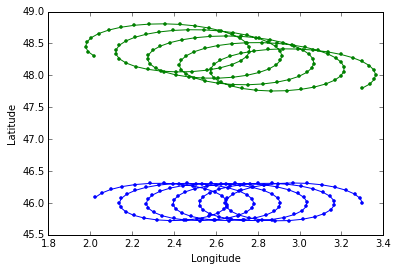

In [7]:
run scripts/plotParticles.py -p EddyParticles.nc

Now one of the neat features of PARCELS is that the particles can be plotted as a movie during execution. To rerun the particles while plotting them on top of the zonal velocity field (`grid.U`), first reinitialise the `ParticleSet` and then re-execute. However, now rather than saving the output to a file, display a movie using the `show_movie` keyword, in this case with the zonal velocity `grid.U` as background

In [8]:
## THIS DOES NOT WORK YET IN THIS IPYTHON NOTEBOOK, BECAUSE OF THE INLINE PLOTTING. 
## IT WILL WORK ON MOST MACHINES, THOUGH
# pset = grid.ParticleSet(size=2, pclass=JITParticle, lon=[3.3, 3.3], lat=[46.0, 47.8])
# pset.execute(AdvectionRK4, 
#              runtime=timedelta(days=6), 
#              dt=timedelta(minutes=5), 
#              interval=timedelta(hours=1),
#              show_movie=grid.U)

## Adding a custom behaviour kernel <a name="customkernel"></a>

A key feature of PARCELS is the ability to quickly create very simple kernels, and add them to the execution. Kernels in this case our little snippets of code that alter the trajectories of the particles. 
In this example, we'll create a simple kernel where particles obtain an extra 5 m/s westward velocity after 1 day. Of course, this is not very realistic scenario, but it nicely illustrates the power of custom kernels.

In [9]:
def WestVel(particle, grid, time, dt):
    if time > 86400:
        uvel = -2.
        particle.lon += uvel * dt / 1852 / 60

Now reset the `ParticleSet` again, and re-execute. Note that we have now changed `kernel` to be `AdvectionRK4 + k_WestVel`, where `k_WestVel` is the `WestVel` function as defined above cast into a `Kernel` object (via the `pset.Kernel` call). Note also that we run in `scipy` mode now (we have changed the `pclass` in the `ParticleSet` to `Particle`); in general it is recommended to run in `scipy` mode when debugging code.

In [10]:
pset = grid.ParticleSet(size=2, pclass=Particle, lon=[3.3, 3.3], lat=[46.0, 47.8])

k_WestVel = pset.Kernel(WestVel)       # casting the WestVel function to a kernel object

pset.execute(AdvectionRK4 + k_WestVel, # simply add kernels using the + operator
             runtime=timedelta(days=3), 
             dt=timedelta(minutes=5), 
             interval=timedelta(hours=1),
             output_file=pset.ParticleFile(name="EddyParticles_WestVel"))

And now plot this new particle field

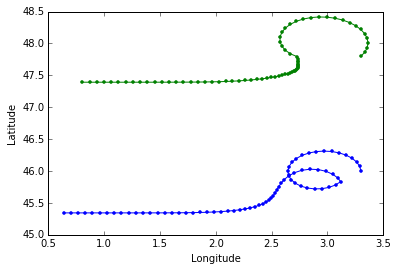

In [11]:
run scripts/plotParticles.py -p EddyParticles_WestVel.nc

## Reading in data from arbritrary NetCDF files <a name="netcdf"></a>

In most cases, you will want to advect particles within pre-computed velocity fields. If these velocity fields are stored in NetCDF format, it is fairly easy to load them into the `Grid.from_netcdf()` function.

The `examples` directory contains a set of [GlobCurrent](http://globcurrent.ifremer.fr/products-data/products-overview) files of the region around South Africa. 

First, define the names of the files containing the zonal (U) and meridional (V) velocities. You can use wildcards (`*`) and the filenames for U and V can be the same (as in this case)

In [12]:
filenames = {'U': "examples/GlobCurrent_example_data/20*.nc",
             'V': "examples/GlobCurrent_example_data/20*.nc"}

Then, define a dictionary of the variables (`U` and `V`) and dimensions (`lon`, `lat` and `time`; note that in this case there is no `depth` because the GlobCurrent data is only for the surface of the ocean)

In [13]:
variables = {'U': 'eastward_eulerian_current_velocity', 
             'V': 'northward_eulerian_current_velocity'}
dimensions = {'lat': 'lat', 
              'lon': 'lon', 
              'time': 'time'}

Finally, read in the grid using the `Grid.from_netcdf` function with the above-defined `filenames`, `variables` and `dimensions`

In [14]:
grid = Grid.from_netcdf(filenames, variables, dimensions)

Now define a `ParticleSet`, in this case with 10 particle starting on a line between (27E, 35S) and (29E, 35S)

In [15]:
pset = grid.ParticleSet(size=10,          # releasing 10 particles
                        pclass=Particle,  # Using scipy mode
                        start=(27, -35),  # releasing on a line: the start longitude and latitude
                        finish=(29, -35)) # releasing on a line: the end longitude and latitude

And finally execute the `ParticleSet` for 1 week using 4th order Runge-Kutta, and show a movie on top of the zonal velocity

In [16]:
pset.execute(AdvectionRK4, 
             runtime=timedelta(weeks=1),
             dt=timedelta(minutes=5),
             interval=timedelta(hours=6),
             output_file=pset.ParticleFile(name="GlobCurrentParticles"))

Now visualise this simulation using the `plotParticles` script again

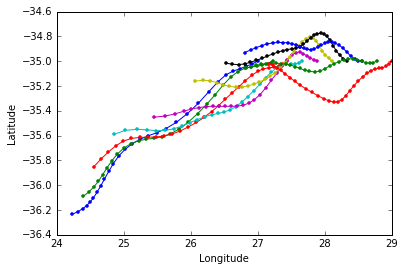

In [17]:
run scripts/plotParticles.py -p GlobCurrentParticles.nc